# CIFAR-10

CIFAR-10 and CIFAR-100 are image datasets commonly used for image recognition competitions. In recent years, machines have been able to reliably beat humans on image classification in these tasks. The 10 categories for CIFAR-10 are airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. Each image is size 32x32, with 3 color channels (red, green, blue).

In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import numpy as np

In [2]:
data = pickle.load(open("Files/cifar-10-python/data_batch_1", 'rb'), encoding='bytes')
data.keys()

dict_keys([b'filenames', b'data', b'labels', b'batch_label'])

In [3]:
X = data[b'data']
X = np.array([i.reshape(3,32,32) for i in X]).astype(np.float32)/255
y = np.array(data[b'labels']).astype(np.long)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)

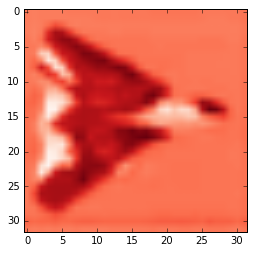

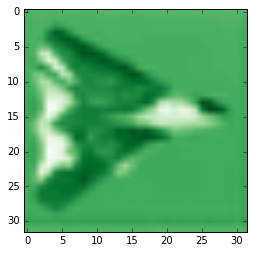

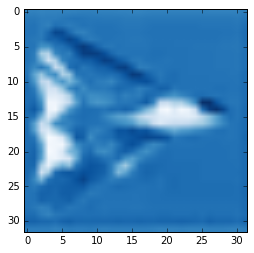

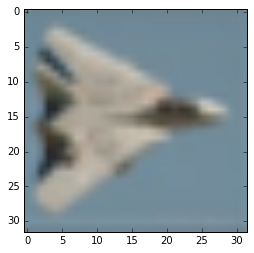

In [5]:
plt.imshow(X_train[0][0], cmap='Reds')
plt.show()
plt.imshow(X_train[0][1], cmap='Greens')
plt.show()
plt.imshow(X_train[0][2], cmap='Blues')
plt.show()
plt.imshow(np.swapaxes(np.swapaxes(X_train[0], 0, 1), 1, 2))
plt.show()

## Building a Net

We will use a convolutional net to train on the CIFAR-10 dataset.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, sampler
import torch.nn.functional as F

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
train_set = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_set = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
train_loader = DataLoader(dataset=train_set, sampler=sampler.RandomSampler(train_set), batch_size=100)
test_loader = DataLoader(dataset=test_set, sampler=sampler.RandomSampler(test_set), batch_size=100)

def eval(model, test_loader):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100 * correct / len(test_loader.dataset)
        train_loss = 0
        correct = 0
        for data, target in train_loader:
            output = model(data)
            train_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct / len(train_loader.dataset)
    return test_loss, test_accuracy, train_loss, train_accuracy

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []
def train(model, train_loader, optimizer):
    model.train()
    for epoch in range(50):
        for data, target in train_loader:
            optimizer.zero_grad()
            prediction = model(data)
            loss = F.cross_entropy(prediction, target)
            loss.backward()
            optimizer.step()
        test_loss, test_accuracy, train_loss, train_accuracy = eval(model, test_loader)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

In [19]:
train(model, train_loader, optimizer)

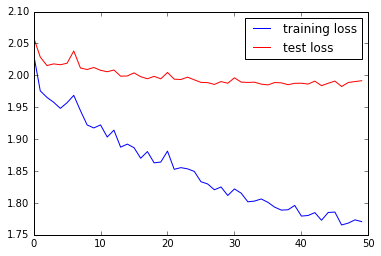

In [20]:
plt.plot(train_loss_history, label='training loss')
plt.plot(test_loss_history, color='red', label='test loss')
plt.legend()
plt.show()

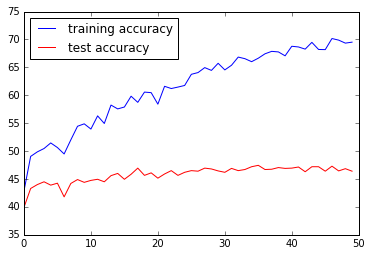

In [21]:
plt.plot(train_accuracy_history, label='training accuracy')
plt.plot(test_accuracy_history, color='red', label='test accuracy')
plt.legend(loc=2)
plt.show()